<AxesSubplot:>

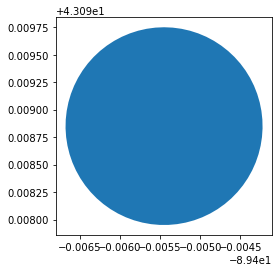

In [1]:
# Read in shapefile and plot to prove successful
import geopandas as gpd
shp_path = "/efs/Shapefiles/Buoy_100m_offset/Buoy_100m.shp"
Mendota_100m=gpd.read_file(shp_path)
Mendota_100m.plot()

In [16]:
# Read in processed DESIS image to check file format
img_path = "/efs/DESIS/L2R/DESIS_HSI_002_2020_06_02_20_11_33_L2R.nc"
img = gdal.Open(img_path)
type(img)

osgeo.gdal.Dataset

In [7]:
#import packages/modules
import tarfile
import xarray as xr
import json
import math
import affine
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from osgeo import gdal,ogr,osr

In [9]:
# Read in clipped AVIRIS image
img_path = "/efs/AVIRIS_processed/ang20160822t192414_rfl_v1n2_img_clipped"
img = gdal.Open(img_path)

In [10]:
# Define bands
# band descriptions. we reference this dictionary throughout the tutorial.
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return(region)

# lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img.GetMetadata().values() if b != "Nanometers"]
em_regions = [classifier(b) for b in band_centers]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers).sort_index()

# print the first ten rows
bands.head(10)

,Band number,Band center (nm),EM region
1,1,376.44,visible-violet
2,2,381.45,visible-violet
3,3,386.46,visible-violet
4,4,391.47,visible-violet
5,5,396.47,visible-violet
6,6,401.48,visible-violet
7,7,406.49,visible-violet
8,8,411.50,visible-violet
9,9,416.51,visible-violet
10,10,421.52,visible-violet


In [12]:
# Extract red, green, and blue bands
# function finds band in our table with wavelength nearest to input r,g,b wavelengths
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

# get band numbers. use R: 667.5nm, G: 540nm, B: 470nm
Ri, Gi, Bi = get_band_number(667.5), get_band_number(540), get_band_number(470)

# function gets numpy array from input band
get_band = lambda b: img.GetRasterBand(int(b["Band number"])).ReadAsArray()

# get r,g,b arrays
Ra, Ga, Ba = get_band(Ri), get_band(Gi), get_band(Bi)

# set fill values (-9999.) to 0 for each array
Ra[Ra == -9999.], Ga[Ga == -9999.], Ba[Ba == -9999.] = 0, 0, 0

#Because we had to force gdal to read the file by not checking data, there are nan values in the matrix.
#Replace these with 0 as well
Ra[np.isnan(Ra)], Ga[np.isnan(Ga)], Ba[np.isnan(Ba)] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
Ra8, Ga8, Ba8 = scale8bit(Ra), scale8bit(Ga), scale8bit(Ba)

# set rescaled fill pixels back to 0 for each array
Ra8[Ra == 0], Ga8[Ga == 0], Ba8[Ba == 0] = 0, 0, 0

# make rgb stack
nbands = img.RasterCount
nrows = img.RasterYSize
ncols = img.RasterXSize
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = Ra8, Ga8, Ba8

/tmp/ipykernel_997/3291364134.py:22: RuntimeWarning: divide by zero encountered in true_divide
  scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')
/tmp/ipykernel_997/3291364134.py:22: RuntimeWarning: invalid value encountered in multiply
  scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')


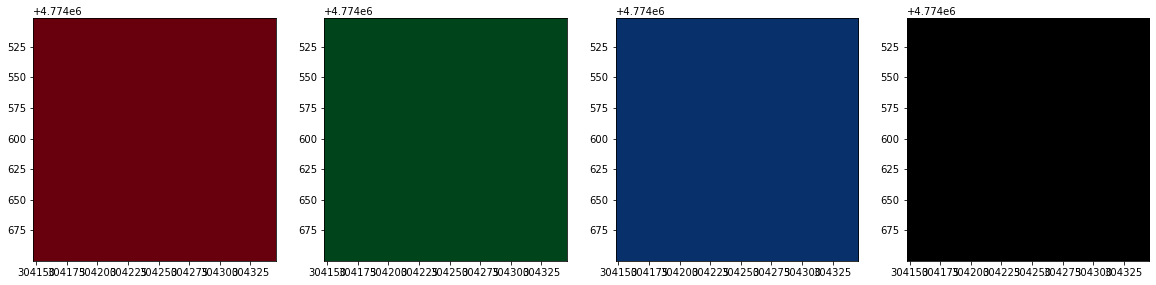

In [14]:
# Plot RGB individual images and RBG image stack
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': Ra8, 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': Ga8, 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': Ba8, 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
xmin, xres, xrot, ymax, yrot, yres = img.GetGeoTransform()
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    #ax.set_title(band, pad = 20, fontdict = titlefont)  
    
plt.imshow(rgb_stack, extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])